<a href="https://colab.research.google.com/github/Fenny-057/E-WasteGeneration-Classification/blob/main/E_WasteClassificationWeek2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import (
    EfficientNetV2B0, EfficientNetV2B3, ResNet50, MobileNetV2
)  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations

In [ ]:
# Replace '/content/archive.zip' with the actual path to your zip file
# Replace '/content/extracted_data' with the directory where you want to extract the files
!unzip /content/archive.zip -d /content/extracted_data

Archive:  /content/archive.zip
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_106.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_128.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_148.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_152.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_174.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_177.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_190.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_192.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_211.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_22.jpg  
  inflating: /content/extracted_data/modified-dataset/test/Battery/battery_24.jpg  
  inflating: /content/extracted_data

In [ ]:
trainpath = r'/content/extracted_data/modified-dataset/train'
testpath = r'/content/extracted_data/modified-dataset/test'
validpath = r'/content/extracted_data/modified-dataset/val'

In [ ]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [ ]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [ ]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [ ]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


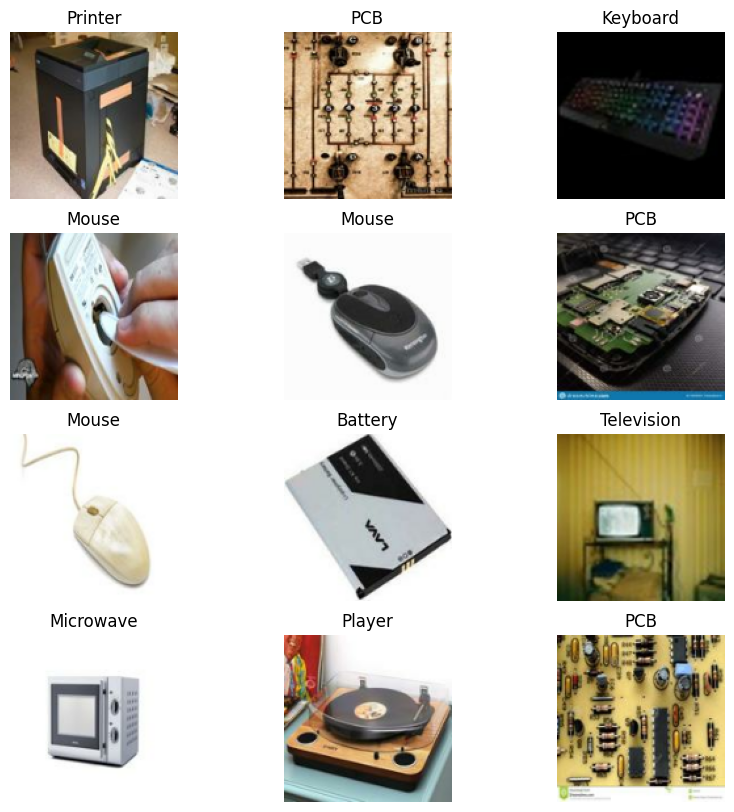

In [ ]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

In [ ]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class

    # Create the bar plot
     # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

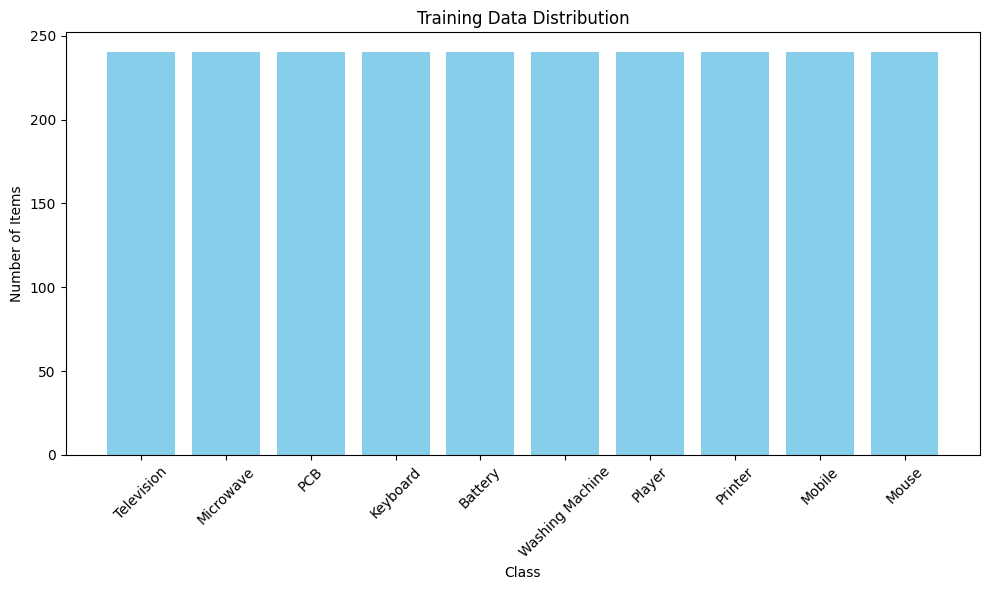

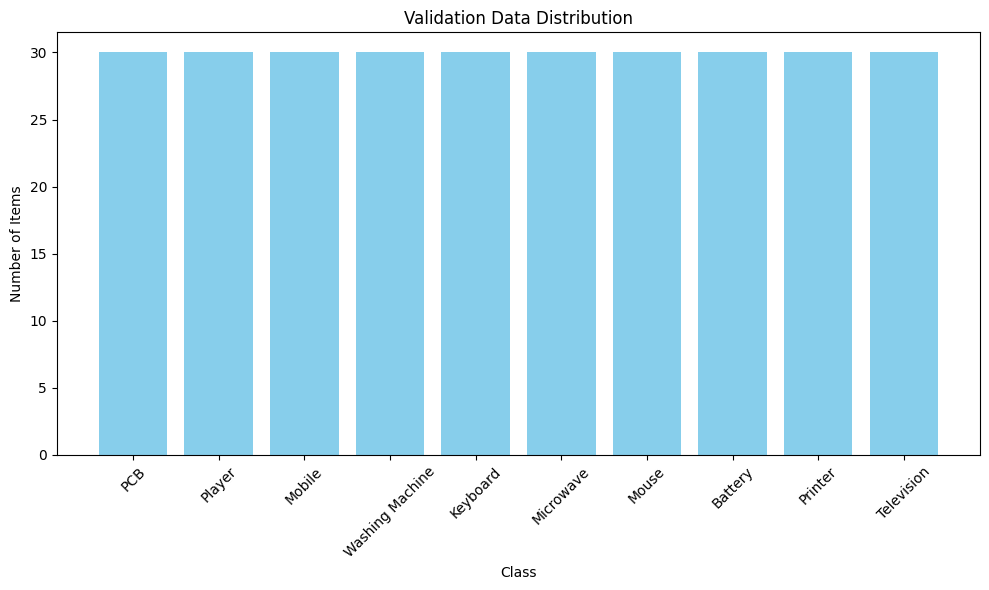

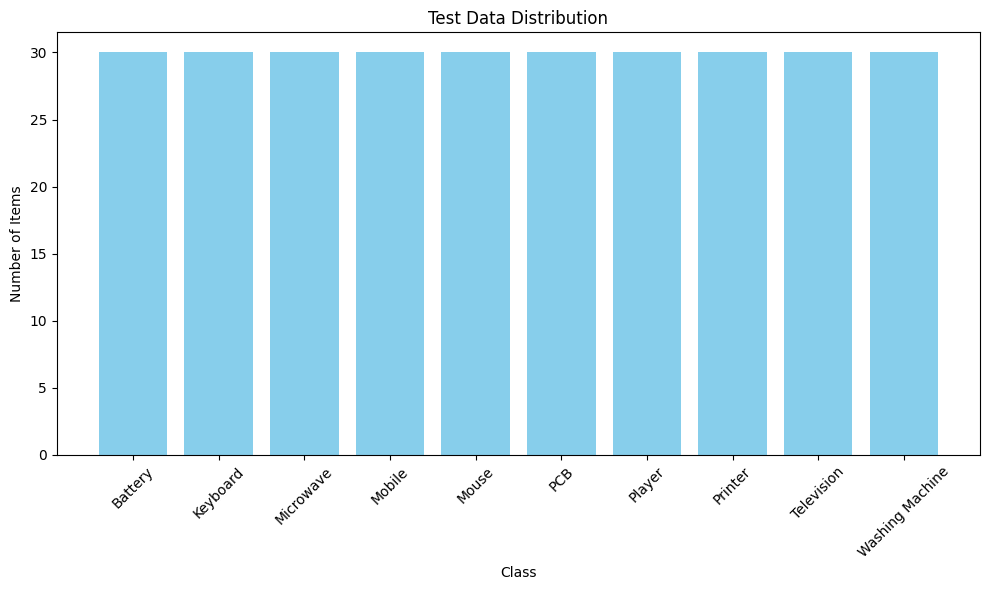

In [ ]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

In [ ]:
#data_augmentation = tf.keras.Sequential([
 #   tf.keras.layers.RandomFlip("horizontal"),
  #  tf.keras.layers.RandomRotation(0.1),
   # tf.keras.layers.RandomZoom(0.1),
#])
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(factor=(-0.2, 0.2)),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    tf.keras.layers.RandomContrast(factor=0.2),
    tf.keras.layers.RandomCrop(height=110, width=110),
    tf.keras.layers.Resizing(128, 128) # Resize back to original size after cropping
])

In [ ]:
#base_model = tf.keras.applications.EfficientNetV2B0(
 #   input_shape=(128, 128, 3),
  #  include_top=False,
   # weights='imagenet'
#)
#base_model.trainable = True
#for layer in base_model.layers[:100]:
 #   layer.trainable = False
model_dict = {
    "EfficientNetV2B0": EfficientNetV2B0,
    "EfficientNetV2B3": EfficientNetV2B3,
    "ResNet50": ResNet50,
    "MobileNetV2": MobileNetV2
}
histories = {}

for model_name, model_func in model_dict.items():
    print(f"\n🔁 Training {model_name}...")

    # Load base model with pretrained ImageNet weights
    base_model = model_func(
        include_top=False,
        weights='imagenet'
    )

    # Fine-tuning strategy
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Full model
    model = models.Sequential([
        data_augmentation,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        datatrain,
        validation_data=datavalid,
        epochs=5,
        verbose=1
    )

    histories[model_name] = history.history



🔁 Training EfficientNetV2B0...
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.1629 - loss: 2.3094 - val_accuracy: 0.5800 - val_loss: 1.6848
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.4747 - loss: 1.6469 - val_accuracy: 0.7667 - val_loss: 1.0433
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6740 - loss: 1.1154 - val_accuracy: 0.8633 - val_loss: 0.6321
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7639 - loss: 0.7891 - val_accuracy: 0.8800 - val_loss: 0.4503
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8446 - loss: 0.5632 - val_accuracy: 0.8967 - val_loss: 0.3613

🔁 Training EfficientNetV2B3...
52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.1506 - loss: 2.2868 - val_accuracy: 0.6000 - val_loss: 1.7164
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.4942 - loss: 1

/tmp/ipython-input-13-3337595249.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = model_func(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 89s 888ms/step - accuracy: 0.1638 - loss: 2.6363 - val_accuracy: 0.1500 - val_loss: 3.3776
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 80s 873ms/step - accuracy: 0.3399 - loss: 1.8844 - val_accuracy: 0.2300 - val_loss: 3.1451
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 911ms/step - accuracy: 0.4397 - loss: 1.6326 - val_accuracy: 0.3167 - val_loss: 2.5731
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 83s 921ms/step - accuracy: 0.4878 - loss: 1.4821 - val_accuracy: 0.3367 - val_loss: 2.4509
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 78s 868ms/step - accuracy: 0.5167 - loss: 1.4088 - val_accuracy: 0.4067 - val_loss: 2.1146


In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,476,640 (24.71 MB)

 Trainable params: 2,026,698 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 4,053,398 (15.46 MB)

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, None,      │        864 │ input_layer_7[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, None,      │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, None,      │          0 │ bn_Conv1[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ expanded_conv_de… │
│ (ReLU)              │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        512 │ expanded_conv_de… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, None,      │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, None,      │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, None,      │          0 │ block_1_expand_B… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, None,      │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, None,      │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │          0 │ block_1_depthwis… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, None,      │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
best_model_name = None
best_accuracy = 0

print("Validation Accuracy of Each Model (Last Epoch):")
for model_name, history in histories.items():
    # Get validation accuracy from the last epoch
    last_epoch_val_accuracy = history['val_accuracy'][-1]
    print(f"{model_name}: {last_epoch_val_accuracy:.4f}")

    # Check if this model has the best accuracy so far
    if last_epoch_val_accuracy > best_accuracy:
        best_accuracy = last_epoch_val_accuracy
        best_model_name = model_name

print(f"\nThe model with the maximum validation accuracy is: {best_model_name} ({best_accuracy:.4f})")

Validation Accuracy of Each Model (Last Epoch):
EfficientNetV2B0: 0.8967
EfficientNetV2B3: 0.8867
ResNet50: 0.8600
MobileNetV2: 0.4067

The model with the maximum validation accuracy is: EfficientNetV2B0 (0.8967)


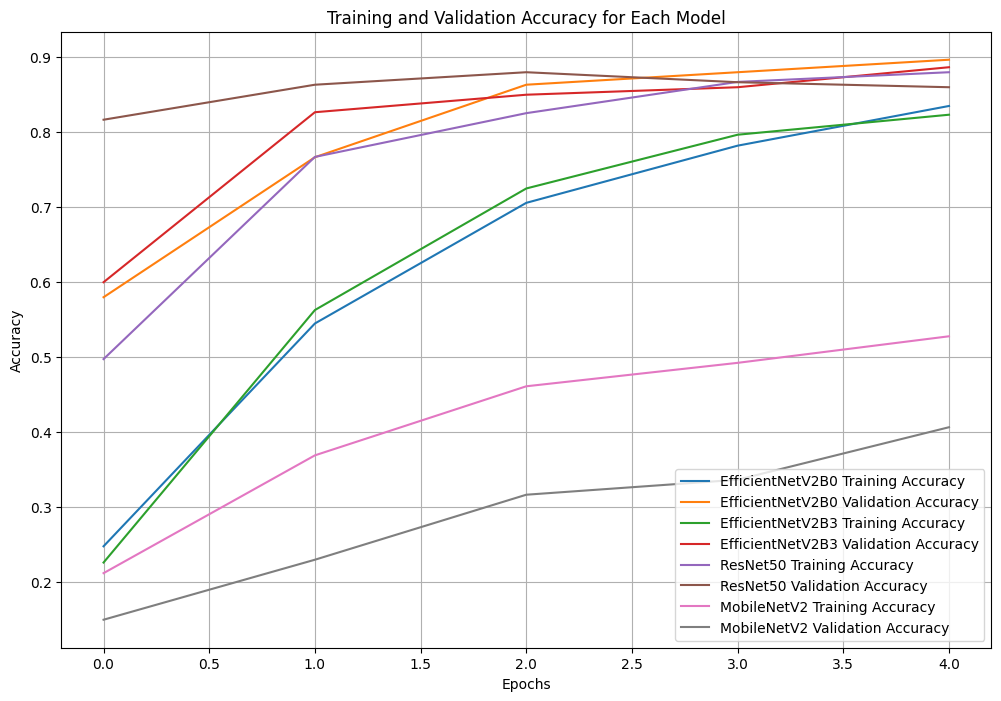

In [ ]:
def plot_accuracy_history(histories):

    plt.figure(figsize=(12, 8))

    for model_name, history in histories.items():
        epochs_range = range(len(history['accuracy']))
        plt.plot(epochs_range, history['accuracy'], label=f'{model_name} Training Accuracy')
        plt.plot(epochs_range, history['val_accuracy'], label=f'{model_name} Validation Accuracy')

    plt.title('Training and Validation Accuracy for Each Model')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_accuracy_history(histories)

In [16]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 450ms/step - accuracy: 0.3175 - loss: 2.4252
Test accuracy is0.3633, Test loss is 2.1996


In [17]:
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 619ms/step
[[11  0  0  0  0  1  9  4  0  5]
 [ 6  5  1  0  0  4  4  2  0  8]
 [ 0  0 10  1  1  0  6  2  0 10]
 [ 0  0  2  2  1  3 12  4  1  5]
 [ 0  0  0  0  8  1 13  1  0  7]
 [ 3  0  0  0  0 15  8  4  0  0]
 [ 3  0  0  0  1  1 19  4  0  2]
 [ 0  0  1  0  6  0  9 13  0  1]
 [ 0  0 11  0  4  0  6  5  1  3]
 [ 0  0  2  0  0  1  0  1  1 25]]
              precision    recall  f1-score   support

           0       0.48      0.37      0.42        30
           1       1.00      0.17      0.29        30
           2       0.37      0.33      0.35        30
           3       0.67      0.07      0.12        30
           4       0.38      0.27      0.31        30
           5       0.58      0.50      0.54        30
           6       0.22      0.63      0.33        30
           7       0.33      0.43      0.37        30
           8       0.33      0.03      0.06        30
           9       0.38      0.83      0.52        30

    accuracy                    

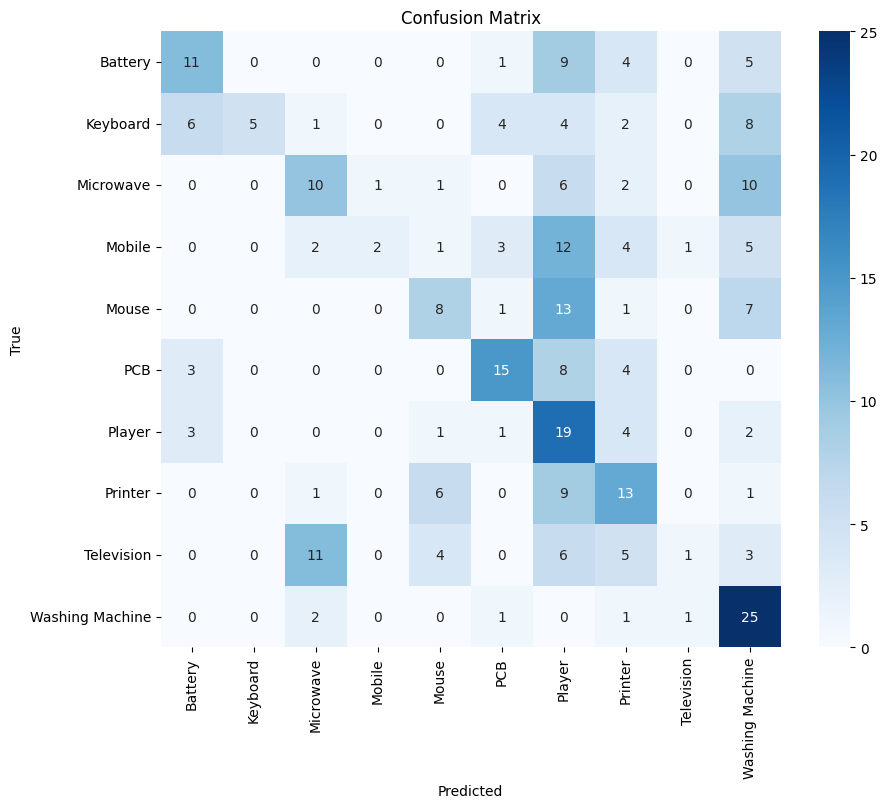

In [18]:
cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


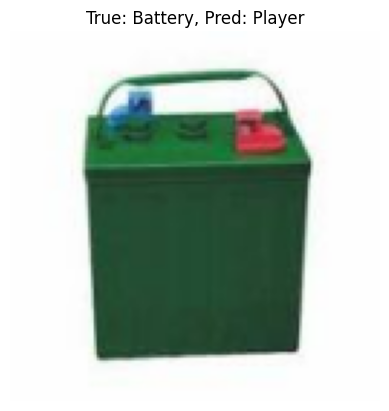

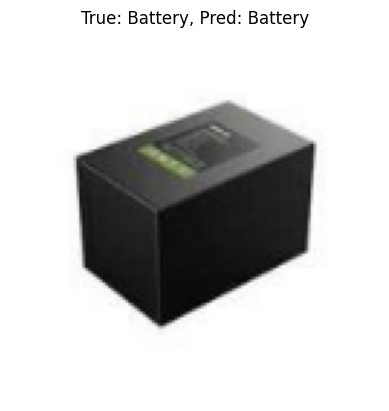

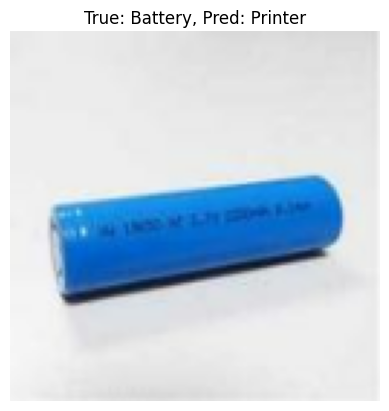

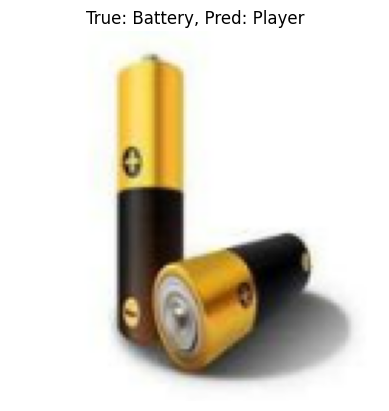

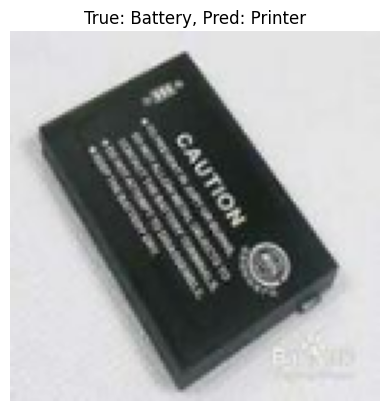

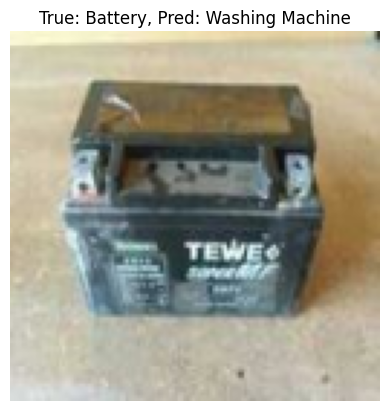

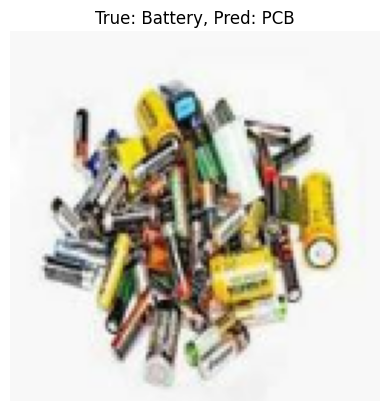

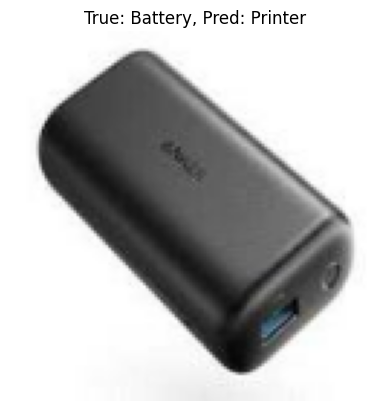

In [19]:
class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()

Since the model with best accuracy is found to be EfficientNetV2B0 after the comparison with EfficientNetV2B3 , Restnet50 , MobileNetV2 . I have decided to proceed with this model and thus by saving it and deploying with gradio.


In [21]:
model.save('Efficient_classify.keras')

In [22]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')

In [23]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"

In [24]:
iface = gr.Interface(
    fn=classify_image,          # The function to run when input is given
    inputs=gr.Image(type="pil"), # Input component: expects an image as a PIL object
    outputs="text"              # Output component: displays the result as plain text
)

# Launch the Gradio interface, opening a local web app to interact with the model
iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6a027b70591bd35c2f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
